Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 4.4 MB/s eta 0:00:00
Implication — Player17: 3912 frames, 0.67 fois/s
Distance totale — Player17: 10278.5 m
Implication — Player17: 3912 frames, 0.67 fois/s
Efficacité (implication/dist) — Player17: 0.0001
  Joueur  Distance totale (km)  Vitesse moyenne (km/h)  Vitesse max (km/h)  Nb de sprints (>7 m/s)  Distance sprint (km)  Dist. haute-intensité (>5.5 m/s) (km)  Ratio HI distance  Accélération max (m/s²)  Position X moy. (m)  Position Y moy. (m)  Surface couverte (m²)  Implication (frames/s)  Efficacité (imp/dist)
Player17             10.278469                 6.37952          1035.02493                     235              0.084313                               0.517398           0.050338              7162.084959            58.827491            47.164945             279.522413                 0.67446               0.000066


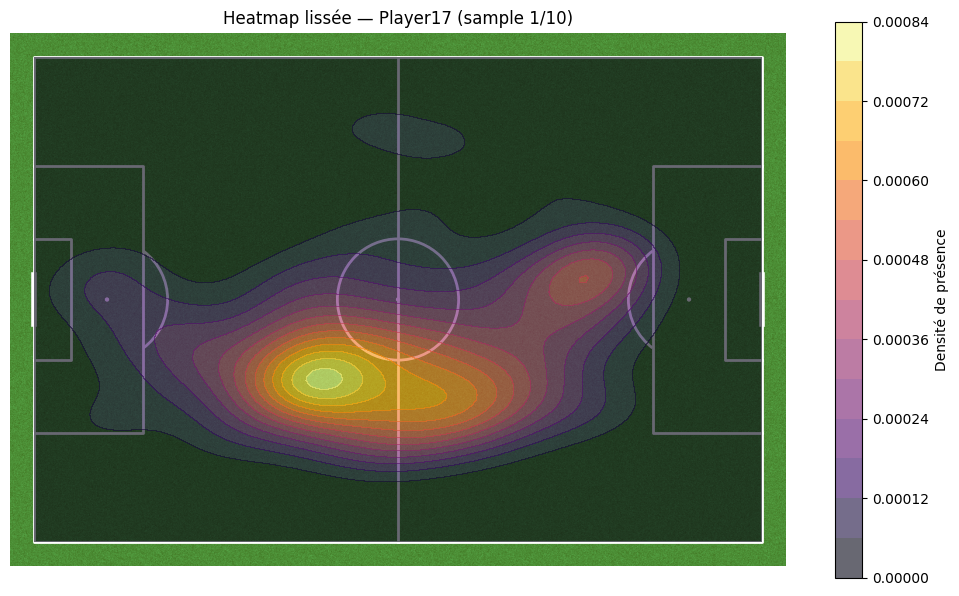

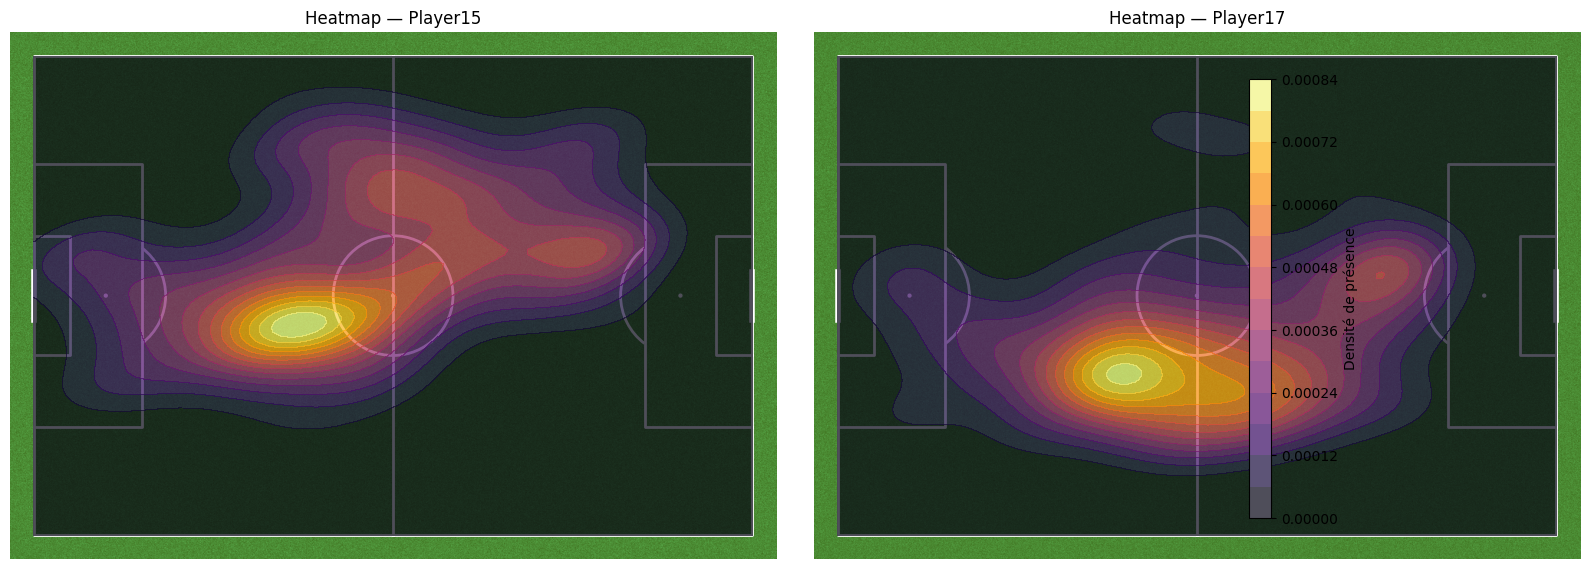


----- Statistiques brutes -----
Distance totale — Player17: 10278.5 m
Vitesse moyenne — Player17: 1.77 m/s
Vitesse max     — Player17: 287.51 m/s
Vitesse moyenne — Player17: 1.77 m/s
Vitesse max     — Player17: 287.51 m/s
Nombre de sprints (> 7.0 m/s) — Player17: 235
Accélération max — Player17: 7162.08 m/s²
Position moyenne — Player17: x=58.8, y=47.2
Surface couverte (convex hull) — Player17: 279.5
Implication — Player17: 3912 frames, 0.67 fois/s
Distance totale — Player17: 10278.5 m
Implication — Player17: 3912 frames, 0.67 fois/s
Efficacité (implication/dist) — Player17: 0.0001


np.float64(6.561867098436049e-05)

In [1]:

from google.colab import drive
drive.mount('/content/drive')


!pip install mplsoccer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from scipy.spatial import ConvexHull


file_path = '/content/drive/MyDrive/Sample_Game_1_RawTrackingData_Away_Team2.csv'
raw = pd.read_csv(file_path, sep=';')

time_col = 'Time [s]'
entities = raw.columns[3::2].tolist()

tracking = []
for i, name in enumerate(entities):
    xcol = raw.columns[3 + i*2]
    ycol = raw.columns[4 + i*2]
    tmp = raw[[time_col, xcol, ycol]].copy()
    tmp.columns = ['Time', 'x', 'y']
    tmp['Entity'] = name if 'Player' in name else 'Ball'
    tracking.append(tmp)

tracking = pd.concat(tracking, ignore_index=True)
tracking['Time'] = tracking['Time'].astype(float)
tracking = tracking.sort_values(['Entity','Time']).reset_index(drop=True)

players_tracking = tracking[tracking['Entity'] != 'Ball']

# Calcul des min/max uniquement sur les joueurs
x_min, x_max = players_tracking['x'].min(), players_tracking['x'].max()
y_min, y_max = players_tracking['y'].min(), players_tracking['y'].max()

# Rescale toutes les coordonnées (même celles de la balle)
tracking['x'] = (tracking['x'] - x_min) / (x_max - x_min) * 105
tracking['y'] = (tracking['y'] - y_min) / (y_max - y_min) * 68


pitch = Pitch(pitch_length=105, pitch_width=68,
              pitch_color='grass', line_color='white')

# Fonctions d'analyse

def plot_heatmap(player, bins=50):
    df = tracking[tracking['Entity']==player]
    if df.empty:
        print(f"Aucune donnée pour {player}")
        return
    fig, ax = pitch.draw()
    heatmap, xedges, yedges = np.histogram2d(
        df['x'], df['y'], bins=bins,
        range=[[0,105],[0,68]]
    )
    heatmap = np.log1p(heatmap)
    ax.imshow(heatmap.T, extent=[0,105,0,68], origin='lower',
              cmap='Reds', alpha=0.6)
    ax.set_title(f"Heatmap de position — {player}")
    plt.show()

def compute_distance(player):
    df = tracking[tracking['Entity']==player]
    dx = df['x'].diff()
    dy = df['y'].diff()
    d = np.sqrt(dx**2 + dy**2)
    total = d.sum()
    print(f"Distance totale — {player}: {total:.1f} m")
    return total

def compute_speed(player):
    df = tracking[tracking['Entity']==player]
    d = np.sqrt(df['x'].diff()**2 + df['y'].diff()**2)
    dt = df['Time'].diff()
    speed = d/dt
    print(f"Vitesse moyenne — {player}: {speed.mean():.2f} m/s")
    print(f"Vitesse max     — {player}: {speed.max():.2f} m/s")
    return speed

def sprint_count(player, thr=7.0):
    speed = compute_speed(player)
    sprints = (speed > thr).sum()
    print(f"Nombre de sprints (> {thr} m/s) — {player}: {sprints}")
    return sprints

def max_acceleration(player):
    df = tracking[tracking['Entity']==player]
    d = np.sqrt(df['x'].diff()**2 + df['y'].diff()**2)
    dt = df['Time'].diff()
    speed = d/dt
    acc = speed.diff()/dt
    print(f"Accélération max — {player}: {acc.max():.2f} m/s²")
    return acc

def average_position(player):
    df = tracking[tracking['Entity']==player]
    x_mean = df['x'].mean()
    y_mean = df['y'].mean()
    print(f"Position moyenne — {player}: x={x_mean:.1f}, y={y_mean:.1f}")
    return (x_mean, y_mean)

def covered_area(player):
    df = tracking[tracking['Entity']==player][['x','y']].dropna().values
    if len(df) < 3:
        return 0
    hull = ConvexHull(df)
    area = hull.area
    print(f"Surface couverte (convex hull) — {player}: {area:.1f}")
    return area

def involvement_score(player, threshold=3):
    df_p = tracking[tracking['Entity']==player]
    df_b = tracking[tracking['Entity']=='Ball']
    merged = pd.merge(df_p, df_b, on='Time', suffixes=('','_ball'))
    dist = np.sqrt((merged['x']-merged['x_ball'])**2+(merged['y']-merged['y_ball'])**2)
    cnt = (dist<=threshold).sum()
    rate = cnt / (df_p['Time'].max()-df_p['Time'].min())
    print(f"Implication — {player}: {cnt} frames, {rate:.2f} fois/s")
    return rate

def efficiency(player):
    dist = compute_distance(player)
    inv = involvement_score(player)
    eff = inv/dist if dist>0 else np.nan
    print(f"Efficacité (implication/dist) — {player}: {eff:.4f}")
    return eff


import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mplsoccer import Pitch

def plot_heatmap_smooth(player, bw_method=0.3, skip=10):
    df = tracking[tracking['Entity'] == player]

    if df.empty:
        print(f"Aucune donnée pour {player}")
        return


    df = df.iloc[::skip]

    x = df['x'].values
    y = df['y'].values

    pitch = Pitch(pitch_length=105, pitch_width=68, pitch_color='grass', line_color='white')


    x_min, x_max = pitch.dim.left, pitch.dim.right
    y_min, y_max = pitch.dim.bottom, pitch.dim.top


    xi, yi = np.mgrid[x_min:x_max:complex(0, 100), y_min:y_max:complex(0, 100)]

    coords = np.vstack([x, y])
    kde = gaussian_kde(coords, bw_method=bw_method)
    zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)

    pitch = Pitch(pitch_length=105, pitch_width=68,
                  pitch_color='grass', line_color='white')
    fig, ax = pitch.draw(figsize=(10, 6))

    cf = ax.contourf(xi, yi, zi, levels=15, cmap='inferno', alpha=0.6)
    fig.colorbar(cf, ax=ax, label="Densité de présence")
    ax.set_title(f"Heatmap lissée — {player} (sample 1/{skip})")
    plt.show()

def compare_players_heatmap(player1, player2, bw_method=0.3, skip=10):
    df1 = tracking[tracking['Entity'] == player1].iloc[::skip]
    df2 = tracking[tracking['Entity'] == player2].iloc[::skip]

    x1, y1 = df1['x'].values, df1['y'].values
    x2, y2 = df2['x'].values, df2['y'].values

    pitch = Pitch(pitch_length=105, pitch_width=68, pitch_color='grass', line_color='white')


    x_min, x_max = pitch.dim.left, pitch.dim.right
    y_min, y_max = pitch.dim.bottom, pitch.dim.top


    xi, yi = np.mgrid[x_min:x_max:complex(0, 100), y_min:y_max:complex(0, 100)]


    kde1 = gaussian_kde(np.vstack([x1, y1]), bw_method=bw_method)
    zi1 = kde1(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)

    kde2 = gaussian_kde(np.vstack([x2, y2]), bw_method=bw_method)
    zi2 = kde2(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    pitch = Pitch(pitch_length=105, pitch_width=68, pitch_color='grass', line_color='white')

    for ax, zi, title in zip(axs, [zi1, zi2], [player1, player2]):
        pitch.draw(ax=ax)
        cf = ax.contourf(xi, yi, zi, levels=15, cmap='inferno', alpha=0.7)
        ax.set_title(f"Heatmap — {title}")

    cbar = fig.colorbar(cf, ax=axs.ravel().tolist(), shrink=0.95, label="Densité de présence")
    plt.tight_layout()
    plt.show()

import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull

def player_summary_table(player, sprint_thr=7.0, hi_thr=5.5):
    # Filtrage
    df = tracking[tracking['Entity'] == player].copy()
    df['dx'] = df['x'].diff()
    df['dy'] = df['y'].diff()
    df['dt'] = df['Time'].diff()
    df['distance'] = np.sqrt(df['dx']**2 + df['dy']**2)
    df['speed_m_s'] = df['distance'] / df['dt']
    df['accel'] = df['speed_m_s'].diff() / df['dt']

    # Métriques
    total_dist_km     = df['distance'].sum() / 1000
    avg_speed_kmh     = df['speed_m_s'].mean() * 3.6
    max_speed_kmh     = df['speed_m_s'].max()  * 3.6

    sprint_mask       = df['speed_m_s'] > sprint_thr
    sprint_count      = sprint_mask.sum()
    sprint_dist_km    = df.loc[sprint_mask, 'distance'].sum() / 1000

    hi_mask           = df['speed_m_s'] > hi_thr
    hi_dist_km        = df.loc[hi_mask, 'distance'].sum() / 1000
    hi_ratio          = hi_dist_km / total_dist_km if total_dist_km>0 else np.nan

    max_acc           = df['accel'].max()
    x_mean, y_mean    = df['x'].mean(), df['y'].mean()

    pts = df[['x','y']].dropna().values
    area_m2 = ConvexHull(pts).area if len(pts)>=3 else np.nan

    involvement_val   = involvement_score(player)
    efficiency_val    = efficiency(player)

    # Création du tableau recap
    summary = pd.DataFrame([{
        'Joueur': player,
        'Distance totale (km)': total_dist_km,
        'Vitesse moyenne (km/h)': avg_speed_kmh,
        'Vitesse max (km/h)': max_speed_kmh,
        'Nb de sprints (>7 m/s)': sprint_count,
        'Distance sprint (km)': sprint_dist_km,
        'Dist. haute-intensité (>5.5 m/s) (km)': hi_dist_km,
        'Ratio HI distance': hi_ratio,
        'Accélération max (m/s²)': max_acc,
        'Position X moy. (m)': x_mean,
        'Position Y moy. (m)': y_mean,
        'Surface couverte (m²)': area_m2,
        'Implication (frames/s)': involvement_val,
        'Efficacité (imp/dist)': efficiency_val
    }])
    return summary



# Exemple d’appel et affichage
df_sum = player_summary_table('Player17')
print(df_sum.to_string(index=False))




# --- VISUELS ---
plot_heatmap_smooth('Player17')
compare_players_heatmap('Player15', 'Player17')

# --- METRIQUES TEXTE ---
print("\n----- Statistiques brutes -----")
compute_distance('Player17')
compute_speed('Player17')
sprint_count('Player17')
max_acceleration('Player17')
average_position('Player17')
covered_area('Player17')
involvement_score('Player17')
efficiency('Player17')

**Analyse de Player17 :**
Sur ce match, Player17 montre un profil très actif, avec plus de 10 km parcourus et une vitesse moyenne élevée. Il enchaîne 235 sprints, mais sur des distances courtes – un signe de jeu explosif, typique d’un milieu relayeur ou d’un joueur de couloir engagé dans le pressing.

Il se distingue par une bonne intensité (plus de 500 m à haute vitesse) et une accélération max très élevée (7,16 m/s²), indiquant une vraie capacité à faire la différence dans les transitions rapides. Sa position moyenne et la surface qu’il couvre montrent qu’il occupe intelligemment l’espace dans la moitié offensive.

Player17 est un joueur très actif dans le cœur du jeu à gauche, capable de projeter ses courses vers l’avant tout en gardant une zone d’influence relativement stable. Ce profil est typique d’un milieu gauche box-to-box, utile pour maintenir les équilibres, alimenter les attaques et presser dans l’axe.